In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

curr_directory = os.getcwd()

# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))

In [2]:
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

In [3]:
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

In [4]:
unique_dates = list(set(dates))

repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]

In [5]:
# Create a class for linear regression
class LinearRegression:
    def __init__(self, step_size=1e-4, max_iter=10000, eps=1e-6, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps

    def sigmoid(self, z): 
        return 1.0 / (1 + np.exp(-z))
        
    def predict(self, x):
        z = np.dot(x.T, self.theta)
        return self.sigmoid(z)
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        update = 0
        for i in range(x_teams.shape[0]):
            x = x_teams[i,:]
            x_new = np.reshape(x, (2*num_players + 1, 1))
            y = np.asscalar(y_teams[i])
            update += (self.predict(x_new) - y)*x_new
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size, index):
        update = 0
        data = np.array(list(zip(x_teams, y_teams)))
        data_shuffle = data
        np.random.shuffle(data_shuffle)
        
        for i in range(batch_size):
            x = data[i, :]
            y = data[:, i]
            update += (y - predict(x))*x
            
        return update
    
    def fit(self, x, y, mini = False):
        iterations = 0
        abs_error = 1
        error_list = []
        batch_size = 32
        ind = 0
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players + 1, 1))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradBatchLossFunction(x, y)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1

                print('Error: {}'.format(abs_error))
        else:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradminiBatchLossFunction(x, y, batch_size, ind)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1
                ind += batch_size

                print('Error: {}'.format(abs_error))
        
        print('Convergence!')
        plt.plot(error_list)
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[:, 0] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:,0]
            
        x = self.add_intercept(x_without_intercept)
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1]+1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
        
    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[team][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[team][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2

In [6]:
test = LinearRegression()
x, y = test.process_data(unique_teams[0:1229], unique_dates[0:1229], unique_game_results[0:1229])

Error: 0.010629322650103348
Error: 0.004314884350833312
Error: 0.0023967367136073486
Error: 0.001809081978377154
Error: 0.0015255132228615528
Error: 0.0013189538432755968
Error: 0.0011478540139983969
Error: 0.0010019254011003778
Error: 0.0008763464782727548
Error: 0.000767753758417666
Error: 0.000673508430463116
Error: 0.0005914737523884323
Error: 0.0005198949800392757
Error: 0.00045731590794833904
Error: 0.0004025169148806732
Error: 0.00035446810467610495
Error: 0.00031229348515138754
Error: 0.0002752433005925124
Error: 0.0002426724216790837
Error: 0.00021402326486778418
Error: 0.00018881212628685587
Error: 0.00016661811474969946
Error: 0.0001470740851784365
Error: 0.000129859130263535
Error: 0.00011469230131516319
Error: 0.00010132731119095582
Error: 8.954803173582297e-05
Error: 7.916464168643781e-05
Error: 7.001031301012052e-05
Error: 6.19383474067391e-05
Error: 5.481969250355607e-05
Error: 4.854078076466669e-05
Error: 4.3001644483304686e-05
Error: 3.81142682664149e-05
Error: 3.3801

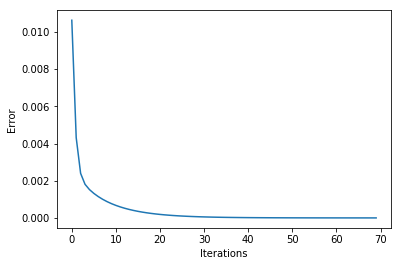

In [7]:
# Fit training set
test.fit(x, y, False)

In [8]:
# Load 2015 playoff data
playoff_data = pd.read_csv(os.path.join(curr_directory,'data_sets/2015_playoffs.csv'))

raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
raw_playoff_dates = np.array(list(playoff_data['Date']))

In [9]:
playoff_pairs = {}

for i in range(len(raw_playoff_team_pairs)): 
    team_1 = raw_playoff_team_pairs[i][0]
    team_2 = raw_playoff_team_pairs[i][1]
    if (team_1,team_2) in playoff_pairs.keys(): 
        # if results > 0 --> team A won --> +1
        # if results < 0 --> team B won --> -1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] += 1
        else: 
            playoff_pairs[team_1,team_2] += -1
    elif (team_2,team_1) in playoff_pairs.keys():
        # if results > 0 --> team B won --> -1
        # if results < 0 --> team A won --> +1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_2,team_1] += -1
        else: 
            playoff_pairs[team_2,team_1] += 1
    else: 
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] = 1
        else: 
            playoff_pairs[team_1,team_2] = -1
            
print(playoff_pairs)

{('WAS', 'TOR'): 4, ('NOP', 'GSW'): -4, ('MIL', 'CHI'): -2, ('DAL', 'HOU'): -3, ('BOS', 'CLE'): -4, ('BRK', 'ATL'): -2, ('POR', 'MEM'): -3, ('SAS', 'LAC'): -1, ('WAS', 'ATL'): -2, ('MEM', 'GSW'): -2, ('CHI', 'CLE'): -2, ('LAC', 'HOU'): -1, ('HOU', 'GSW'): -3, ('CLE', 'ATL'): 4, ('CLE', 'GSW'): -2}


In [12]:
playoff_teams = []
playoff_results = []
playoff_dates = []

for key in playoff_pairs: 
    playoff_teams.append([key[0], key[1]])
    playoff_results.append(playoff_pairs[key])
    playoff_dates.append('2015-04-10')
    
playoff_teams = np.array(playoff_teams)
playoff_results = np.array(playoff_results)
playoff_dates = np.array(playoff_dates)
    
playoff_x, playoff_y = test.process_data(playoff_teams, playoff_dates, playoff_results)

predicted_y = []
for i in range(playoff_x.shape[0]):
    x = playoff_x[i,:]
    x_new = np.reshape(x, (2*num_players + 1, 1))
    prediction = test.predict(x_new)
    if np.asscalar(prediction) > 0: 
        predicted_y.append(1)
    else: 
        predicted_y.append(0)

In [13]:
prediction_accuracy = np.mean(predicted_y == list(playoff_y))
print(predicted_y)
print(playoff_y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]
